# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). At the very bottom of the notebook, you'll find some unit tests to check the correctness of your neural network. Be sure to run these before you submit your project.

After you've submitted this project, feel free to explore the data and the model more.



In [628]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


/Users/Xp/anaconda/envs/dlnd/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split', 'e', 'mean', 'record', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [629]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.drop('instant',axis=1, inplace=True)

In [630]:
# Print 5 records
print(rides.head())

   dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  1/1/11       1   0     1   0        0        6           0           1   
1  1/1/11       1   0     1   1        0        6           0           1   
2  1/1/11       1   0     1   2        0        6           0           1   
3  1/1/11       1   0     1   3        0        6           0           1   
4  1/1/11       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  casual  registered  cnt  
0  0.24  0.2879  0.81        0.0       3          13   16  
1  0.22  0.2727  0.80        0.0       8          32   40  
2  0.22  0.2727  0.80        0.0       5          27   32  
3  0.24  0.2879  0.75        0.0       3          10   13  
4  0.24  0.2879  0.75        0.0       0           1    1  


In [631]:
# Check ridership information and statistics
print(rides.info())
print(rides.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 2.1+ MB
None
             season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.1069

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

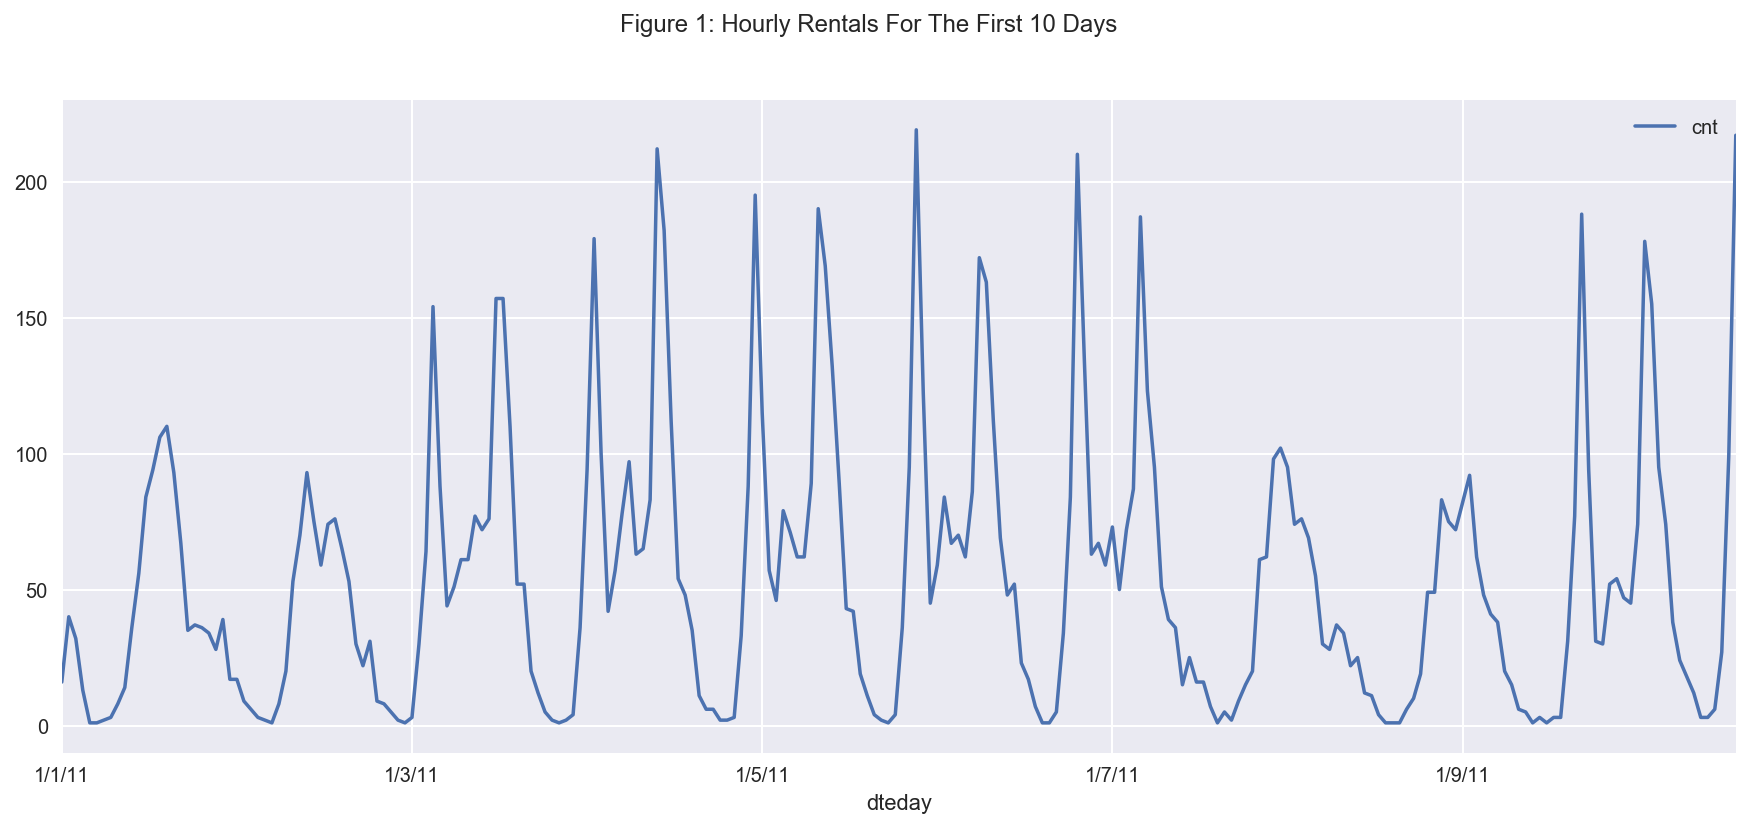

In [632]:
fig=plt.figure()
rides[:24*10].plot(x='dteday',y='cnt')
plt.suptitle('Figure 1: Hourly Rentals For The First 10 Days ')
plt.show()

            casual  registered
weekday                       
0        56.163469  121.305356
1        28.553449  155.191206
2        23.580514  167.658377
3        23.159192  167.971313
4        24.872521  171.564144
5        31.458786  164.677121
6        61.246815  128.962978


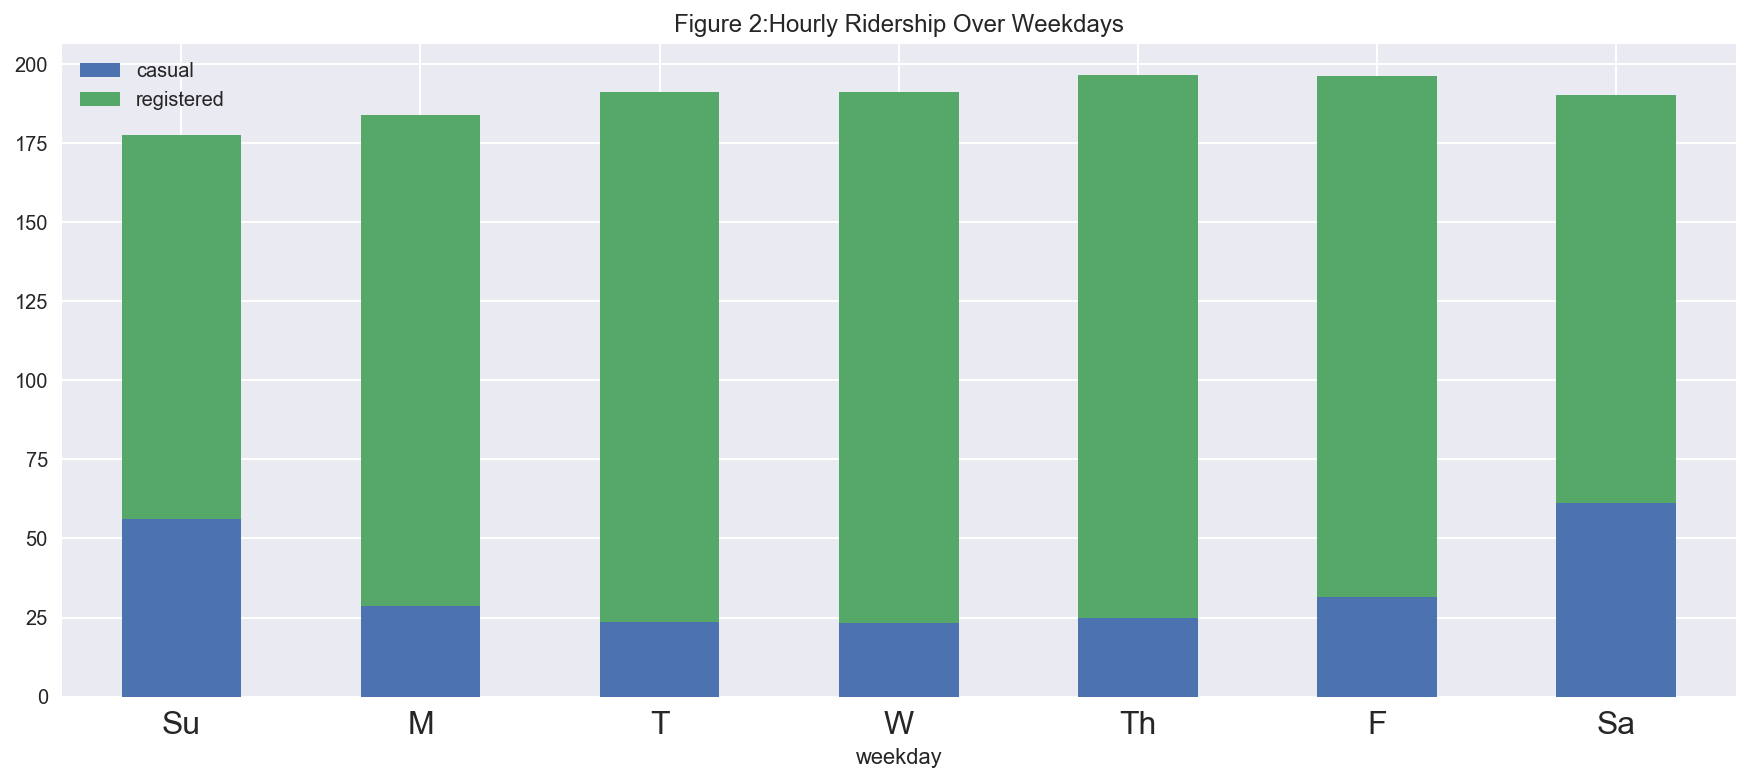

In [633]:
# Ridership over weekday
rides_weekday=rides.groupby('weekday').mean()[['casual','registered']]
print(rides_weekday)
rides_weekday.plot(kind='bar',stacked=True)
plt.title('Figure 2:Hourly Ridership Over Weekdays')
plt.xticks([0,1,2,3,4,5,6],['Su','M','T','W','Th','F','Sa'],rotation=360,fontsize=16)
plt.show()


In [634]:
# Calculate the proportion of casual riders over all riders

proportion=rides_weekday['casual']/(rides_weekday['casual']+rides_weekday['registered'])
rides_weekday['casual/all']=proportion
rides_weekday




,casual,registered,casual/all
weekday,,,
0,56.163469,121.305356,0.316469
1,28.553449,155.191206,0.155397
2,23.580514,167.658377,0.123304
3,23.159192,167.971313,0.121170
4,24.872521,171.564144,0.126619
5,31.458786,164.677121,0.160393
6,61.246815,128.962978,0.321996


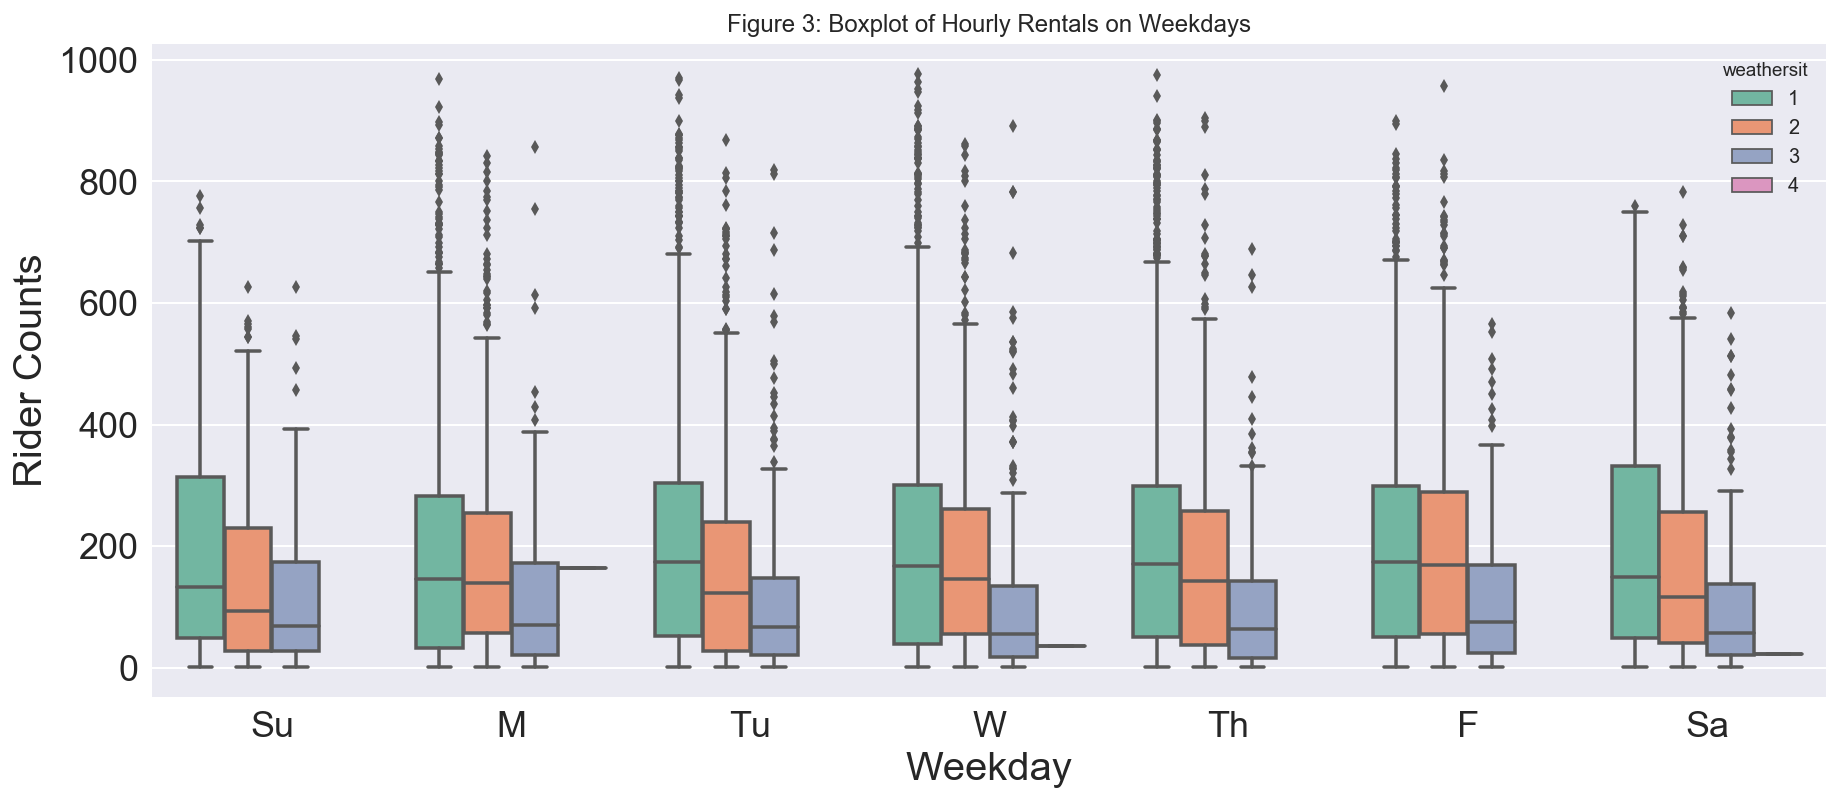

In [635]:
sns.boxplot(x='weekday',y='cnt',hue='weathersit',data=rides,palette="Set2")
plt.xticks([0,1,2,3,4,5,6],['Su','M','Tu','W','Th','F','Sa'],fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Weekday',fontsize=20)
plt.ylabel('Rider Counts',fontsize=20)
plt.title('Figure 3: Boxplot of Hourly Rentals on Weekdays')

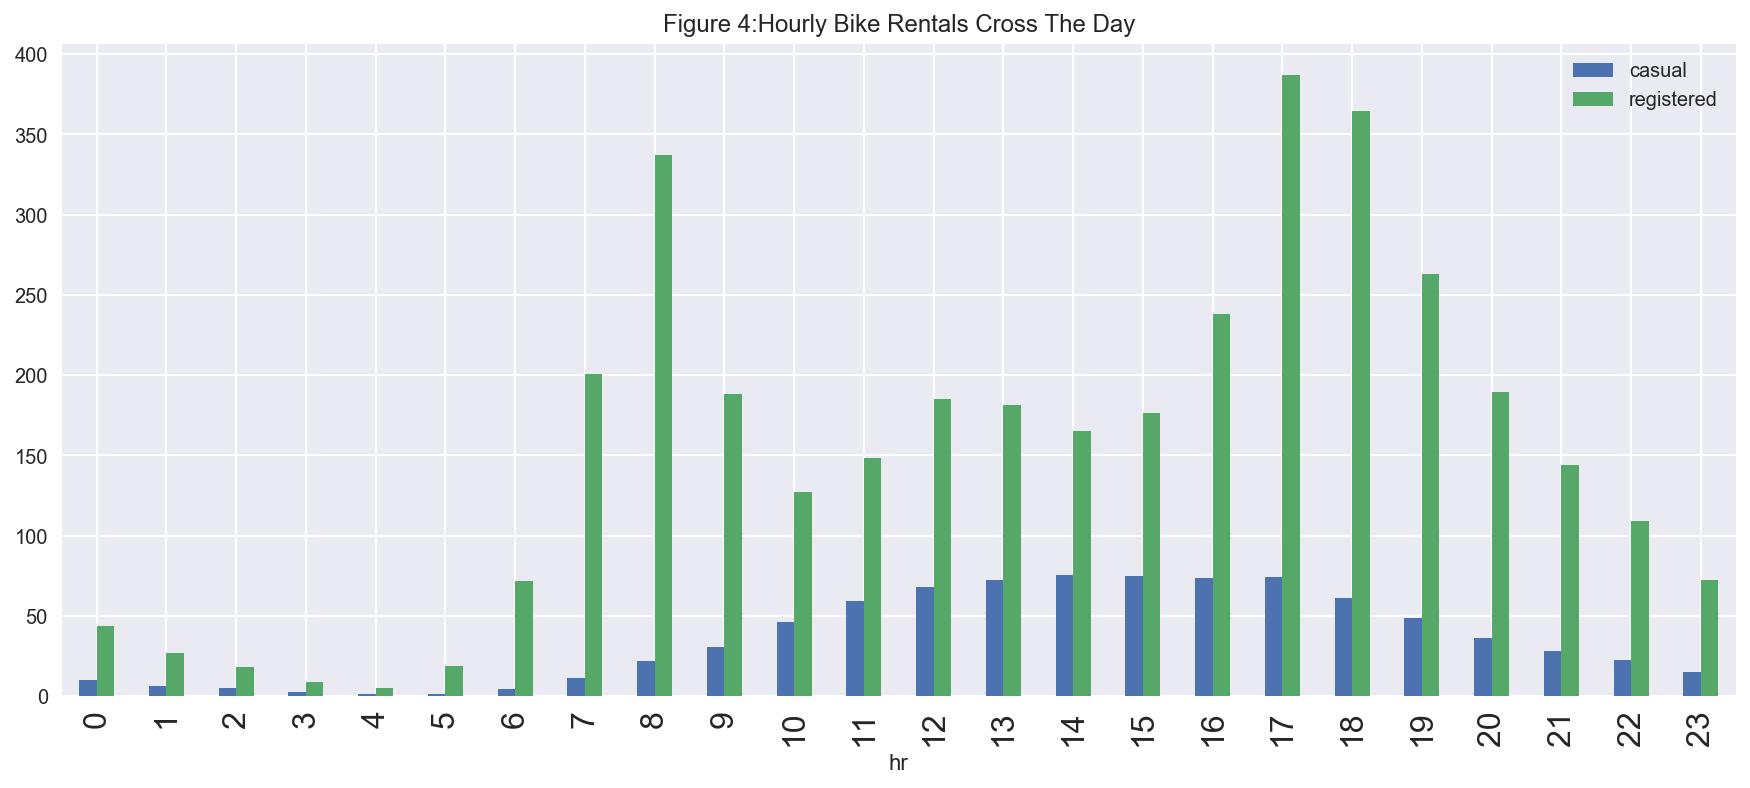

In [636]:
#Ridership over hours
rides_hour=rides.groupby('hr').mean()[['casual','registered']]
rides_hour.plot(kind='bar')
plt.xticks(np.arange(0, 24, 1.0),fontsize=16)
plt.title('Figure 4:Hourly Bike Rentals Cross The Day')
plt.show()

           casual  registered
season                       
1       14.290901   96.823668
2       46.160581  162.183488
3       50.287144  185.729093
4       30.666824  168.202032


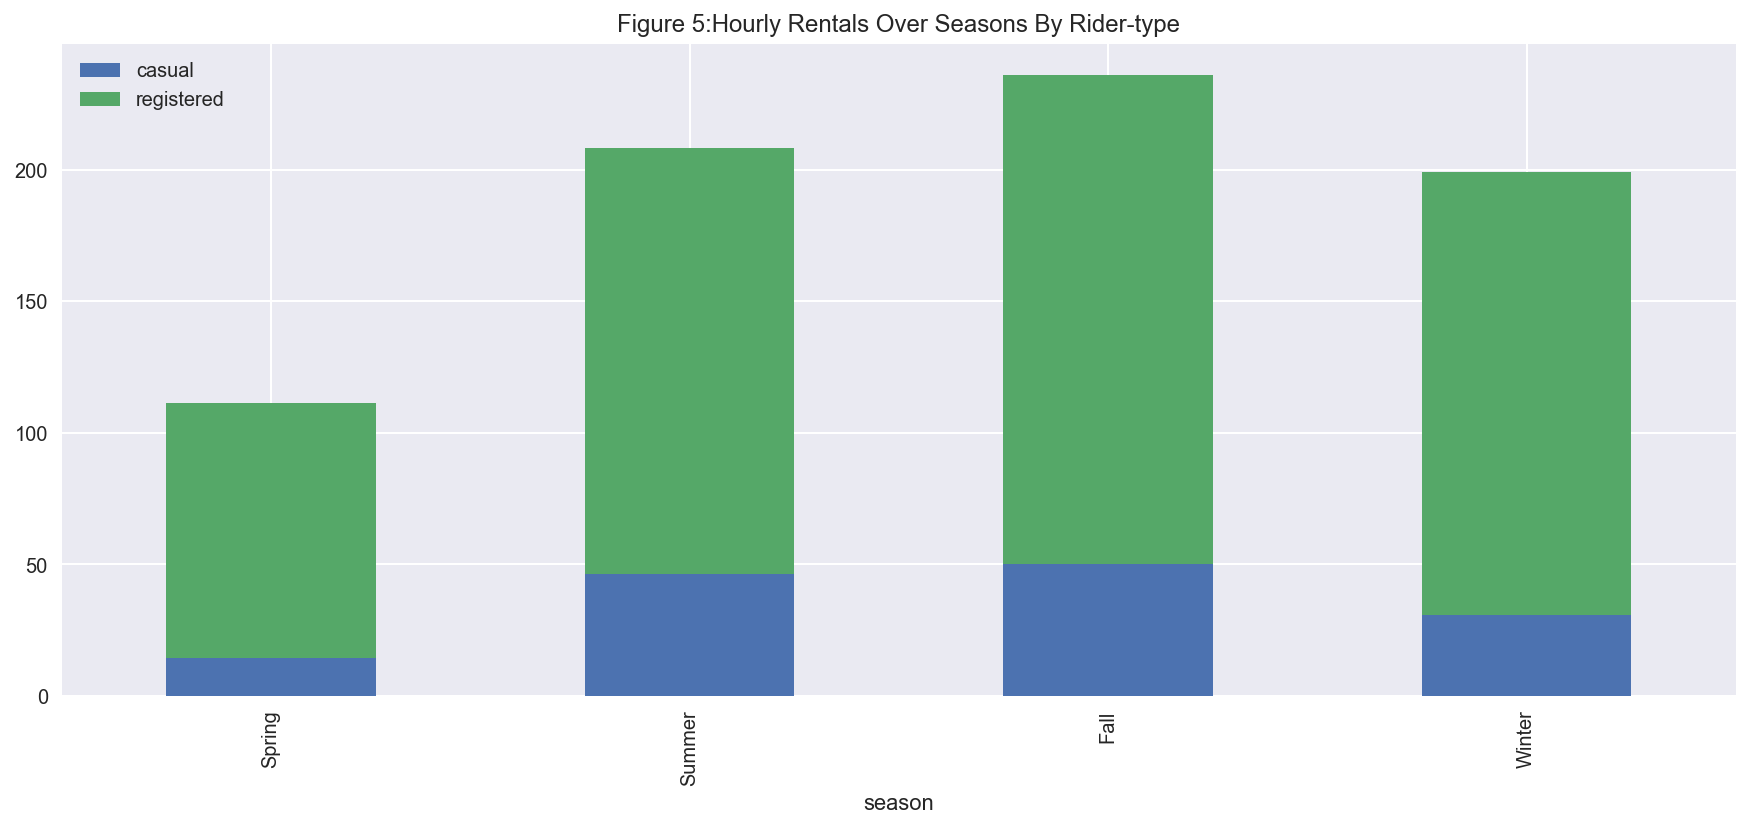

In [637]:
#Ridership over season
rides_season=rides.groupby('season').mean()[['casual','registered']]
print(rides_season)
rides_season.plot(kind='bar',stacked=True)
plt.title('Figure 5:Hourly Rentals Over Seasons By Rider-type')
plt.xticks([0,1,2,3],['Spring','Summer','Fall','Winter'])
plt.legend(loc='upper left')
plt.show()

         casual  registered
mnth                       
1      8.426872   85.997901
2     11.158091  101.706935
3     30.172437  125.238289
4     42.311761  144.949200
5     50.594758  172.312500
6     51.323611  189.191667
7     52.524866  179.295027
8     48.840000  189.257627
9     48.937370  191.835769
10    41.185389  180.973122
11    25.471816  151.863605
12    14.627782  127.675657


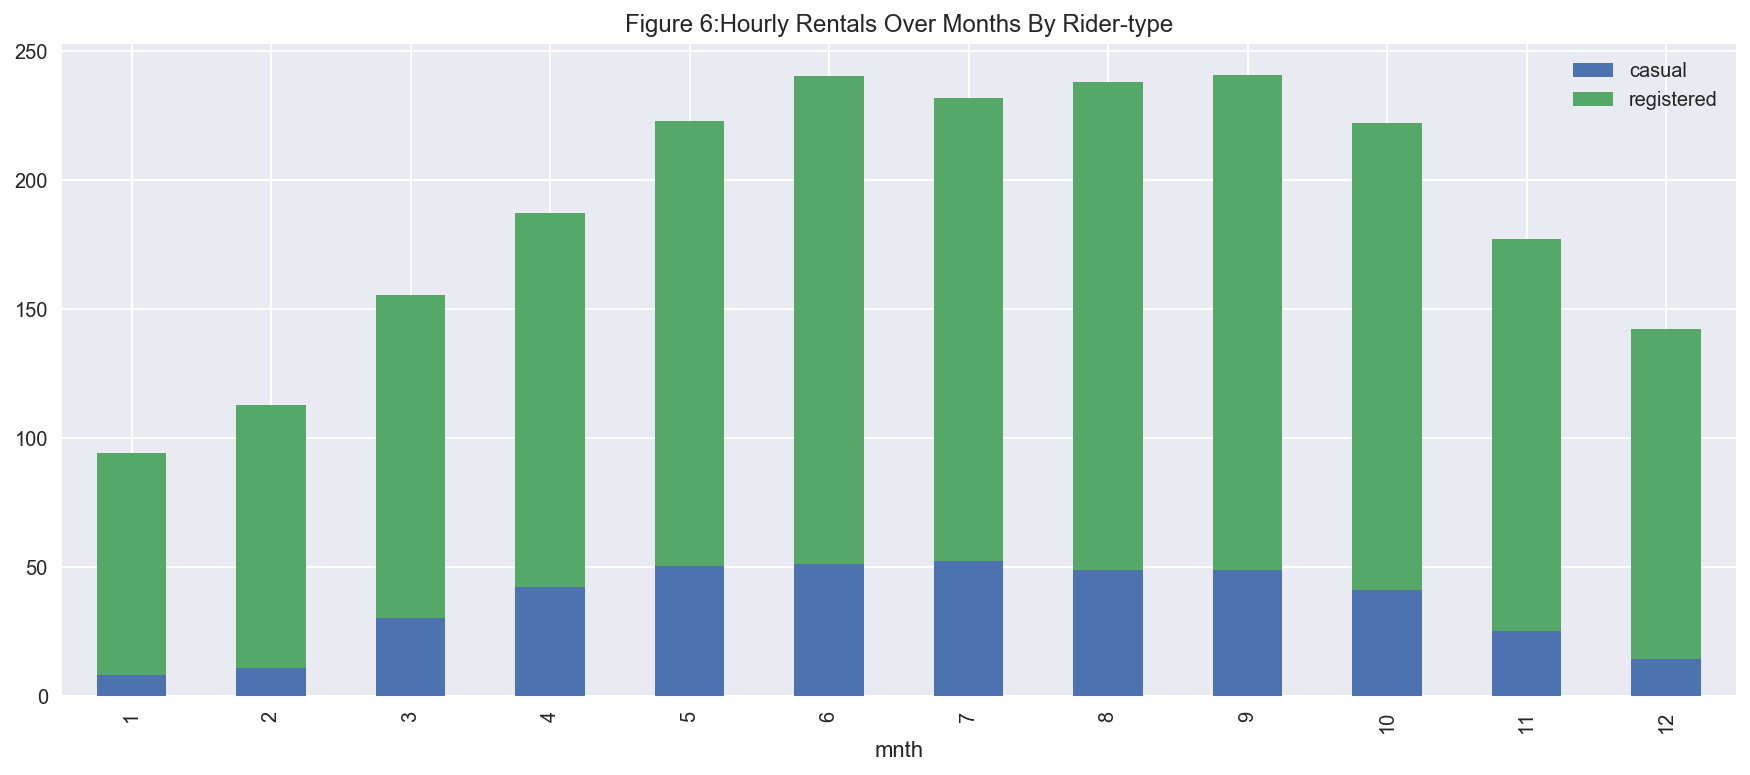

In [638]:
# Ridership Over Months
rides_months=rides.groupby(['mnth']).mean()[['casual','registered']]
print(rides_months)
rides_months.plot(kind='bar',stacked=True)
plt.xticks()
plt.title('Figure 6:Hourly Rentals Over Months By Rider-type')
plt.show()

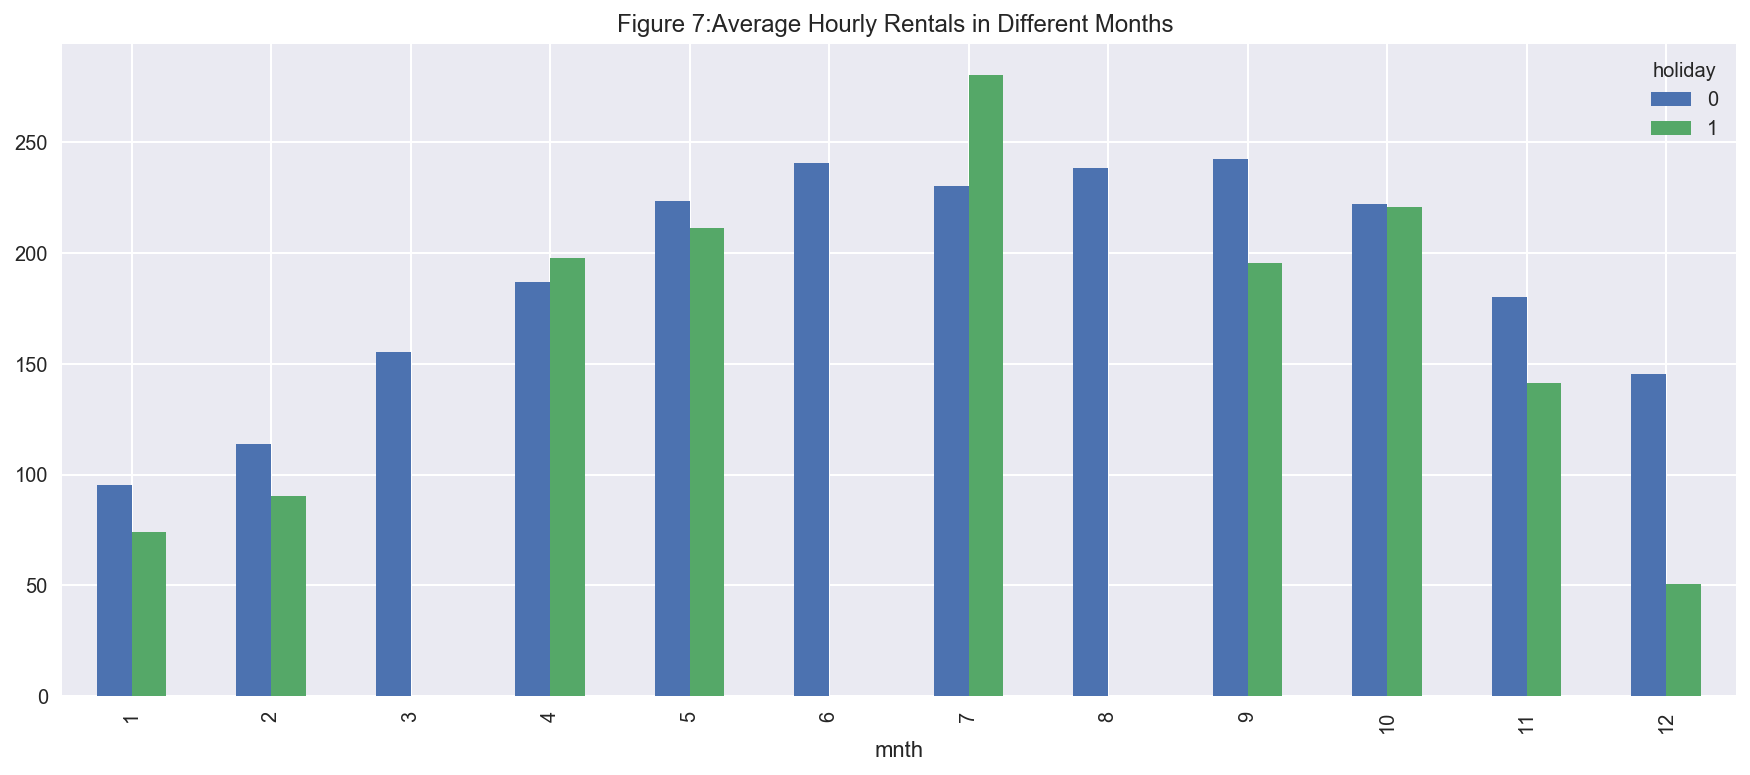

In [639]:
# Monthly Ridership seperated by if it is a holiday
rides_months_holiday=rides.groupby(['mnth','holiday']).mean()['cnt']
rides_months_holiday.unstack(level=1).plot(kind='bar')
plt.title('Figure 7:Average Hourly Rentals in Different Months ')


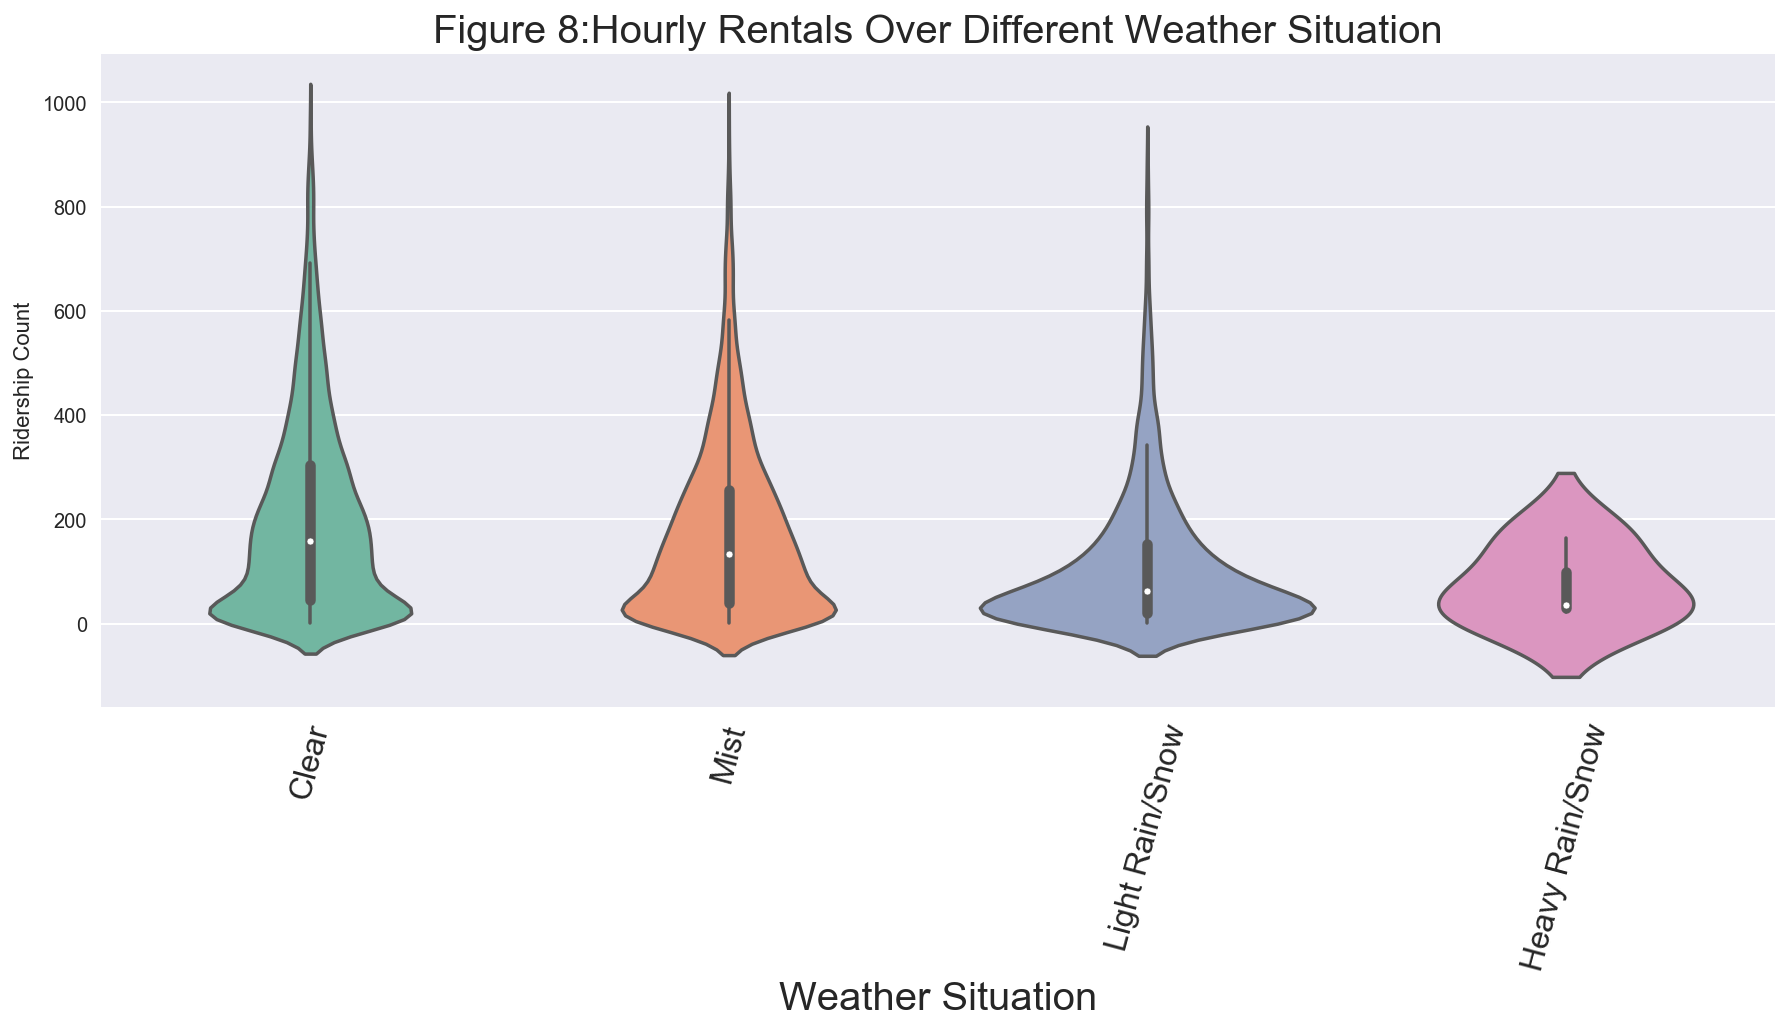

In [640]:
# Ridership Over Different Weather Situation
sns.violinplot(x='weathersit',y='cnt',data=rides,palette="Set2")
plt.xticks([0,1,2,3],['Clear','Mist','Light Rain/Snow','Heavy Rain/Snow'],rotation=75,fontsize=16)
plt.title('Figure 8:Hourly Rentals Over Different Weather Situation',fontsize=20)
plt.xlabel('Weather Situation',fontsize=20)
plt.ylabel('Ridership Count')


/Users/Xp/anaconda/envs/dlnd/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


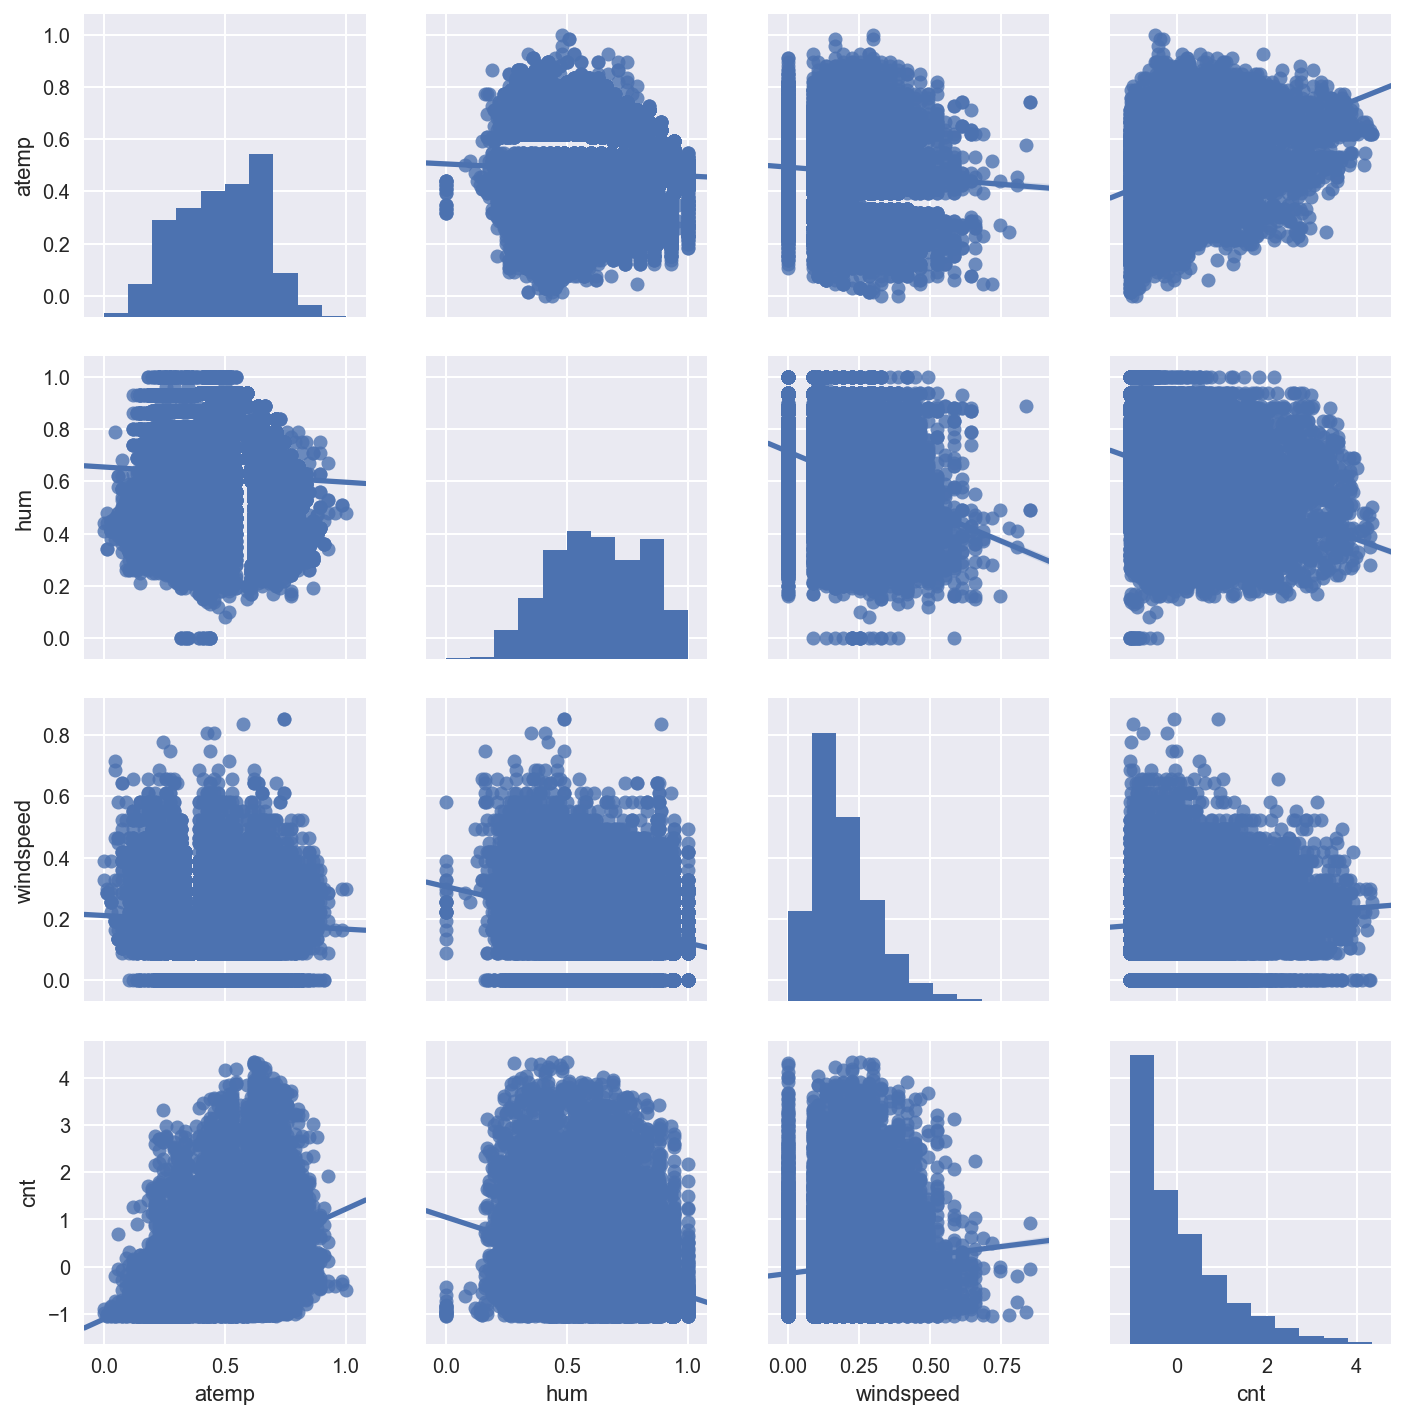

In [641]:
# Check if ridership has linear regression relationship with temperature,humidity and windspeed
rides_thw=rides[['atemp','hum','windspeed','cnt']]
# Standarlize fields of temperature, humidity and windspeed
mean, std = rides_thw.loc[:,'cnt'].mean(), rides_thw.loc[:,'cnt'].std()
rides_thw.loc[:,field] = (rides_thw.loc[:,field]-mean)/std

sns.pairplot(rides_thw,kind='reg')

### Summary of data exploratory

    1.The average bike ridership is about 190 per hour,but varies at different time cross the day. The morning rentals start busy at 7am, and at 8am reaches the moring peak over 350 riders per hour. From 9am to 4pm, the daytime usage is stable with 150 usage per hour.  The ridership peaks over 480 usages at 5pm in the afternoon, and continues to be heavily used over 420 ridings per hour at 6pm. The ridings slow down at 7pm in the evening.
    
    2.Comparing casual and registered customers, it seems the registered customers use bicycles the most time on 8am, 5pm and 6pm,more likely for work communation.  However the casual customers ride the bikes most in the afternoon 12:00PM to 5PM,likely for exercise or fun.
    
    3. The casual riders are acounted for over 30% of the customers during the weekend,but only 15% during working-days. The regiserted customers are accounted for 85% on working days. It means casual customers are more likely to show up on Saturday and Sunday.
    
    4. During different months, bicycle usage is slow on Dec.,Jan., and Feb. and the usage is about 100 riders per hour.  The riding starts to pick up on March and get more popular during the Summer and Fall times,averagely 250 riders per hour. And it is interesting winter hourly useage is close to 200 riders per hour, almost doubled compared with that in Spring. 
    
    5. Under different weather conditions, there are over 150 riders per hour when clear or mist. When light rain or light snow, customers sill use bicycles but the ridings decrease to approximately 75 riders per hour. There are barely any riders when there is heavy rain or heavy snow.
    
    6. Bike ridership has positive linear relationship with temperature and windspeed, which means the bike rentals increase with temperature and windspeed increase. Humidity has negative impact on bike rentals. When humidity increases, the bike users decrease. 



### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [642]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [643]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [644]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]
print("Number of test data: {0}".format(len(test_data)))
print("Number of train and validation data: {0}".format(len(data)))

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']

features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Number of test data: 504
Number of train and validation data: 16875


We'll split the data into two sets, one for training and one for validating as the network is being trained. It's important to split the data randomly so all cases are represented in both sets.

In [645]:
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. . You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [646]:
#Calculate sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [647]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                                (self.hidden_nodes, self.input_nodes))
    
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.output_nodes, self.hidden_nodes))
        
        self.learning_rate = learning_rate
        
        #DEBUG to not print over each epoch
        self.DEBUG = True 
        
        #### Set this to your implemented sigmoid function ####
        # TODO: Activation function is the sigmoid function
        self.activation_function = sigmoid
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        # signals into hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs)
        # signals from hidden layer
        hidden_outputs =self.activation_function(hidden_inputs) 
        
        # TODO: Output layer
        # signals into final output layer
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)
        # signals from final output layer
        final_outputs = final_inputs*1
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        # Output layer error is the difference between desired target and actual output.
        output_errors = targets-final_outputs
        output_grad=output_errors
        
        # TODO: Backpropagated error
        # errors propagated to the hidden layer
        hidden_errors = np.dot(self.weights_hidden_to_output.T,output_errors)
        hidden_grad = hidden_errors*hidden_outputs*(1-hidden_outputs)# hidden layer gradients
        
        
        # TODO: Update the weights
        # update hidden-to-output weights with gradient descent step
        self.weights_hidden_to_output += self.learning_rate*np.dot(hidden_outputs,output_grad.T).T
        #update input-to-hidden weights with gradient descent step
        self.weights_input_to_hidden += self.learning_rate*np.dot(inputs,hidden_grad.T).T    
        
        if self.DEBUG :
            print("input.shape:",inputs.shape)
            print("targets.shape:",targets.shape)
            print("self.weights_hidden_to_output.shape: ", self.weights_hidden_to_output.shape)
            print("output_errors.shape: ", output_errors.shape)
            print("hidden_errors.shape: ", hidden_errors.shape)
            print("hidden_outputs.shape: ", hidden_outputs.shape)
            print("hidden_grad.shape: ", hidden_grad.shape)
            print()
            self.DEBUG = False
    
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        # signals into hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs)
        # signals from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        # TODO: Output layer
        # signals into final output layer
        final_inputs =np.dot(self.weights_hidden_to_output,hidden_outputs) 
        # signals from final output layer
        final_outputs =final_inputs 
        
        return final_outputs

In [648]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network faster. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. However, it can become too specific to the training set and will fail to generalize to the validation set. This is called overfitting. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [649]:
### Set the hyperparameters here ###
epochs = 5000
learning_rate = 0.02
hidden_nodes = 15
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    if e%(epochs/10) == 0:
        # Calculate losses for the training and test sets
        train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
        # Print out the losses as the network is training
        print('Training loss: {:.4f}'.format(train_loss))
        print('Validation loss: {:.4f}'.format(val_loss))
        

input.shape: (56, 1)
targets.shape: (1, 1)
self.weights_hidden_to_output.shape:  (1, 15)
output_errors.shape:  (1, 1)
hidden_errors.shape:  (15, 1)
hidden_outputs.shape:  (15, 1)
hidden_grad.shape:  (15, 1)

Training loss: 0.9320
Validation loss: 0.9336
Training loss: 0.1270
Validation loss: 0.1341
Training loss: 0.0730
Validation loss: 0.0790
Training loss: 0.0667
Validation loss: 0.0723
Training loss: 0.0659
Validation loss: 0.0704
Training loss: 0.0557
Validation loss: 0.0620
Training loss: 0.0543
Validation loss: 0.0614
Training loss: 0.0588
Validation loss: 0.0649
Training loss: 0.0537
Validation loss: 0.0599
Training loss: 0.0558
Validation loss: 0.0627


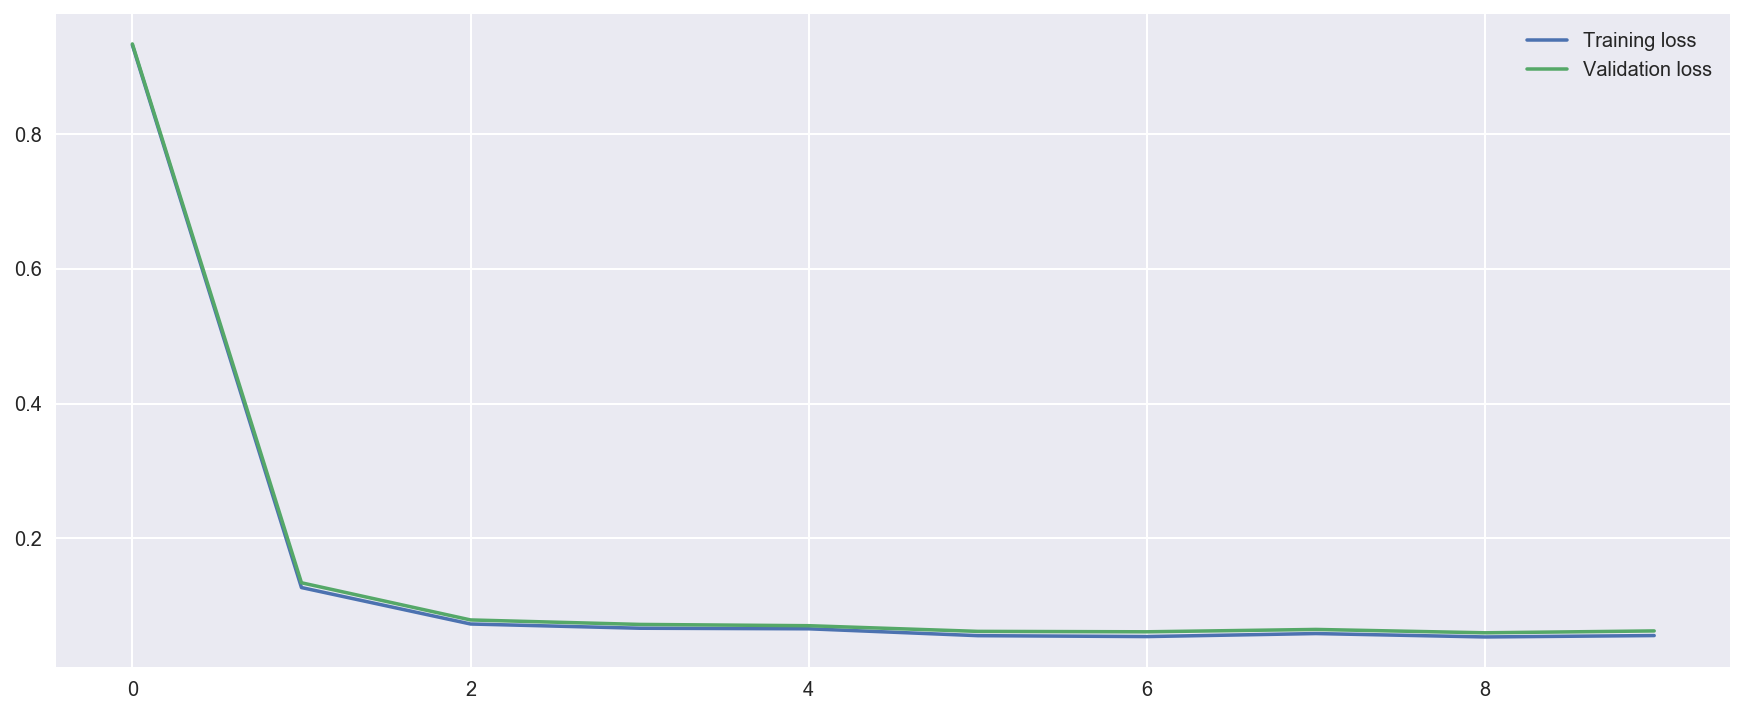

In [650]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

## Check out your predictions

Here, use the test data to check that network is accurately making predictions. If your predictions don't match the data, try adjusting the hyperparameters and check to make sure the forward passes in the network are correct.

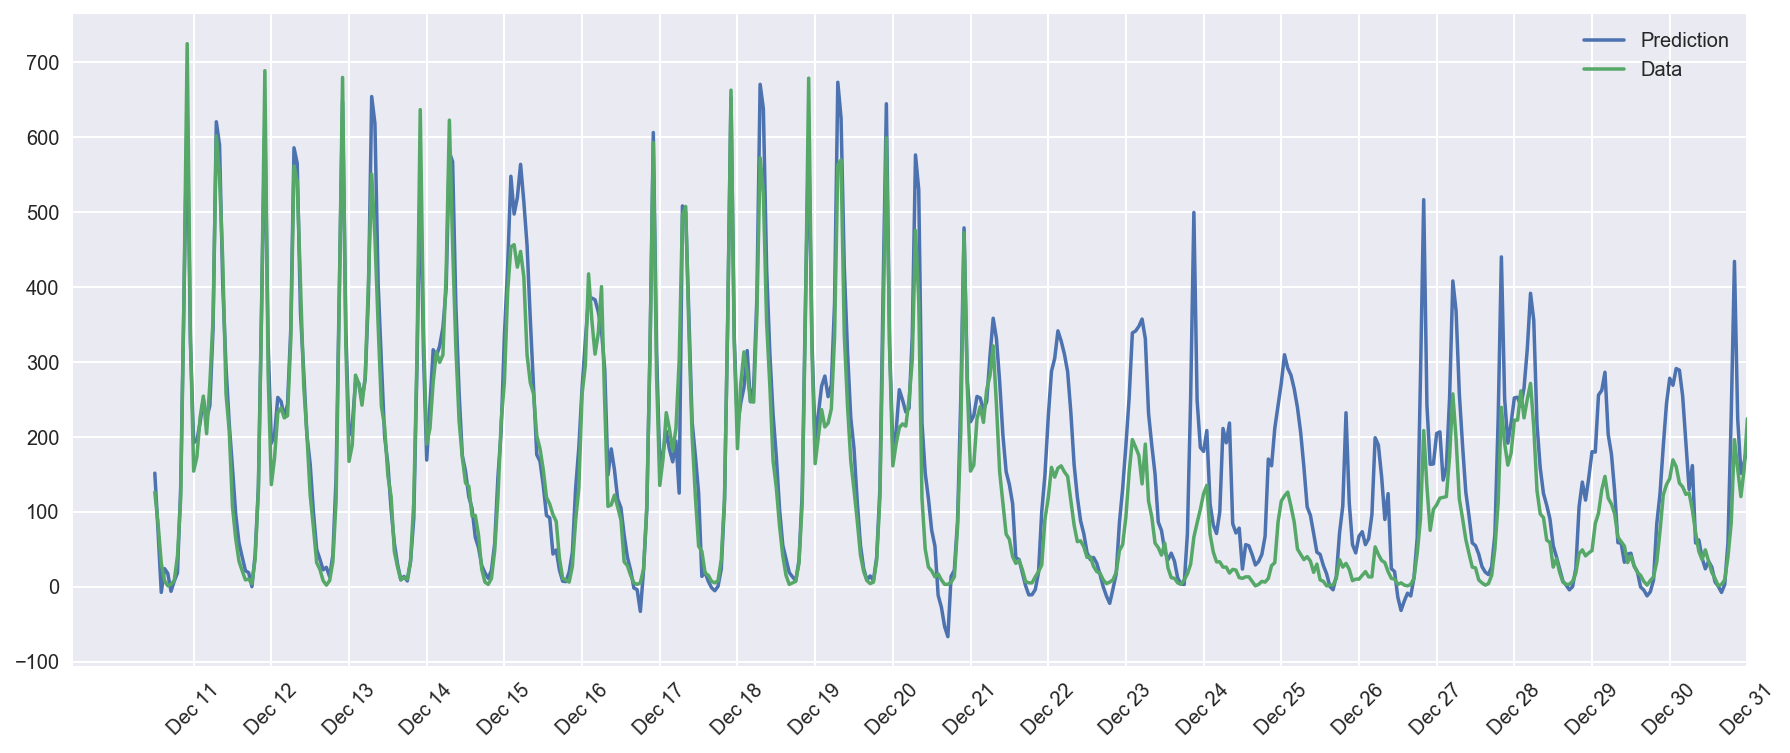

In [651]:
fig, ax = plt.subplots(figsize=(15,6))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()
dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)


## Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

According to the prediction figure above, the model predicted the first 10 days ridership pretty accurately. The prediction runs closely with the rides data from Dec.11th  to Dec.21st. However between Dec.22nd to Dec.26th, for those 4 days,the prediction runs off the rides data, doubling the actual ridership. On Dec.29th and Dec.30th, the model failed to predict the ridership again, also doubling the ridership with the real data.

Analyzing the data on Dec. 2012, accoding to figure 7 generated previously, the hourly rental on holidays is just 30% of non-holiday houly usage. Checking other months, the hourly usage is about the same level for both holiday and non-holiday. 

Dec.21st to Dec.26th, and Dec.20th to Dec.30th, are the Chrismas and New Year holidays. Most of people are travelling back home to spend time with families. When the user ridership drop significantly because of holiday, the model is not able to predict the usage accuately. This is the limitation of our Nerual Network model.




## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [652]:
import unittest

np.random.seed(42)
inputs = [0.5, -0.2, 0.1]
targets = [0.4]

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path == 'Bike-Sharing-Dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    [ 0.22931895, -1.28754157]))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    [[-0.7128223, 0.22086344, -0.64139849],
                                     [-1.06444693, 1.06268915, -0.17280743]]))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.allclose(network.run(inputs), -0.97900982))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

input.shape: (3, 1)
targets.shape: (1, 1)
self.weights_hidden_to_output.shape:  (1, 2)
output_errors.shape:  (1, 1)
hidden_errors.shape:  (2, 1)
hidden_outputs.shape:  (2, 1)
hidden_grad.shape:  (2, 1)




----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>